# UMAP for Flow Cytometry - Part 2

> an application of UMAP on real flow cytometry data for embedding and visualisation

- toc:true
- badges: true
- comments: false
- author:  Marie-Anne Mawhin
- categories: [embedding, dimensionality reduction, flow]

# UMAP for flow cytometry data

UMAP can be used for flow analysis with several aims as described in details in the [doc](https://umap-learn.readthedocs.io/) from UMAP, e.g. to plot high-dimensional data or to reduce dimension before clustering.  
Here, we will explore how UMAP can help in the visualisation of cardiac immune cell response during chronic kidney disease by looking at changes in cardiac leukocyte subtypes.  


## Getting the data ready for it

![](http://25.media.tumblr.com/40db982e13ff34b1be89a713fc7f99d9/tumblr_mgrjtiz4KC1s2yegdo1_400.gif)

### From FlowJo to gated data



A real cool tool available for python is **[Flowkit](https://flowkit.readthedocs.io/en/latest/)**. You can use this tool to extract data that have been gated with GatingML 2.0 or FlowJo 10. I willl focus here on a FlowJo workspace as this is were I did my gating.


To work with FlowJo workspace you need to first call a ```Session``` to get your **FCS** and import your **workspace** in it. Then you need to apply the gating to the **sample group** (the group from your FlowJo workspace structure).

In [ ]:
fks_fj = fk.Session('../data/raw_data')
fks_fj.import_flowjo_workspace('../data/raw_data/FJ_workspace.wsp')
analysis = fks_fj.analyze_samples('group')



To get your labelled gated sampled all you need to do is:

1.Get a dataframe of the gating raw results where in the column events you will have an array of booleans for each gates

In [ ]:
gates = pd.DataFrame(fks_fj.get_gating_results('group', 'sample')._raw_results).loc['events'] #where sample is your sample's name ◔‿◔
gates = pd.DataFrame(gates.droplevel(1)).transpose()

2.Explode the arrays into single rows

In [ ]:
gated = pd.DataFrame()
for col in gates.columns:
    gated[col] = gates[col].explode(ignore_index=True)

3.Merge it back with the fluorescence values of each single cell  


Here you can also select only a subpopulation if you know what is your population of interest (for example not the singlets)

In [ ]:
features  = gated.merge(fkj.get_sample('sample').as_dataframe('raw'), left_index=True, right_index=True)

> Tip: ```fks_fj.get_gate_hierarchy``` is a useful call to check your gating strategy if you have forgotten it

Now that you have extracted your data, there is just one last crucial step.

### Preprocessing: arcsinh

Data from high intensity values are spread on a log scale but the problem with log-scale is that it does not do well on the 'low-end' of the intensity scale, especially since some fluorescence values are zero or sometimes negative (following baseline correction). To solve this problem, bi-exponential transformation have been applied to flow data to approach log for high values and  linearity for data around zero.  
The ArcSinh transform is close to the classic bi-exponential, with a linear representation near zero and a log-like scale beyond a certain threshold, but it is equation-based. The threshold or co-factor determines the compression of the low-end values, the higher the more data are compressed close to zero. Here, data were transformed using **arcsinh with a co-factor of 150** as suggested by [Bendall](https://science.sciencemag.org/content/332/6030/687). 


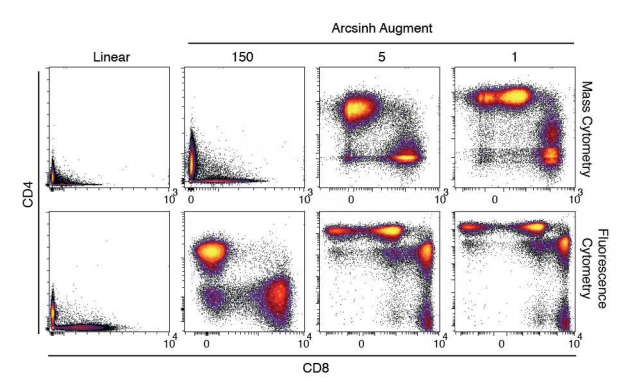

<font size="2"> <span style="color:grey"> Arcsinh transformation adapted from [Bendall et al.](https://science.sciencemag.org/content/332/6030/687) </span> </font>

In [10]:
umap_data = np.arcsinh(features.values / 150.0).astype(np.float32, order='C')

> Note: It is good practice to validate the cofactor value and the transformation by visualising each channel to avoid under/over compression.

### Our data

The data use in this case study come from a flow analysis of immune cells in healthy heart vs chronic kidney disease heart. The panel uses 10 antibodies to identify 7 populations of immune cells.
<div>
<img src=attachment:10ad823f-6795-4ce1-8967-8b639f6f4dd3.png width="400"/>
</div>



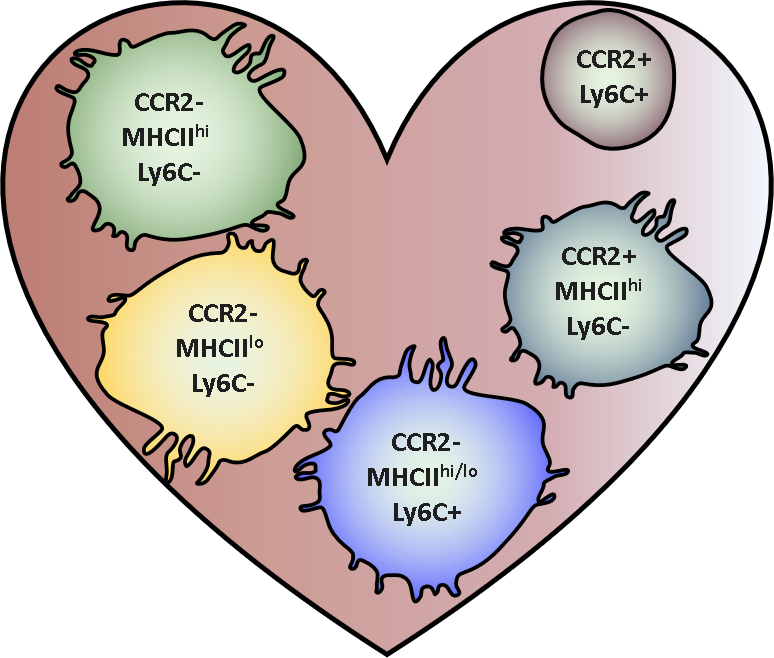

<font size="2"> <span style="color:grey"> Adapted from Epelman et al. 2014 </span> </font>

## Non-parametric UMAP

In [141]:
#hide
data = pd.read_csv('../../Figure_article/UMAP/data/merged_sham_nx.csv')
leuko = data[data.leukocytes].reset_index(drop=True)
leuko.drop(['Unnamed: 0','Singlets 1', 'Singlets 2', 'live', 'cells'], axis=1, inplace=True)

for col in ['R1_', 'R2_', 'R3', 'R4', 'PMNs', 'LIN+', 'CCR2+_']:
    leuko[[col]] = leuko[[col]].replace({True:col, False:''})
    leuko['subtype'] = leuko[[col]]

leuko['subtype'] = leuko[['R1_', 'R2_', 'R3', 'R4', 'PMNs', 'LIN+', 'CCR2+_']].sum(axis=1)

leuko.loc[leuko['subtype'] == '', 'subtype'] = 'leukocytes'
leuko.loc[leuko['subtype'] == 'R2_R4', 'subtype'] = 'R2'
leuko.subtype = leuko.subtype.str.strip('_')

leuko['subtype'] = pd.Categorical(leuko.subtype)

features = leuko[['FSC-W_', 'SSC-W_', 'BV421-A_Lin',
                                      'BV510-A_Ly6C', 'FITC-A_F4/80', 'BV605-A_Ly6G', 'PE-Cy7-A_CD11b',
                                      'BV 785-A_CD45', 'APC-A_MHCII', 
                                      'PE-A_CCR2']]

umap_data = np.arcsinh(features.values / 150.0).astype(np.float32, order='C')
labels = leuko.subtype

Let's explore what UMAP do. The [library](https://umap-learn.readthedocs.io/en/latest/) provides a really detailed documentation and also nice functions to explore UMAP.

UMAP is used in the style of most sklearn models: instantiate and fit or fit/transform.

The library also offers utility functions:

```plot.points```: plot a scatter plot.  
```plot.connectivity```: to plot the connection between each points.  
```plot.diagnostic```: to diagnose the embedding.  

> Reminder of parameters:  
```n_neighbors```: number of neighbours for the high dimensional graph.  
```min_dist```: minimum distance between points in low dimension,i.e. how tight the points are clustered. 

In [11]:
import umap.plot
import umap

#common usage
mapper = umap.UMAP()
embedding = mapper.fit(umap_data)

### Neighbours and minimum distance

Let's test what happen when we modify the hyperparameters:

In [96]:
def draw_umap(n_neighbors=15, min_dist=0.1, title=''):
   
    mapper = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=42
    ).fit(umap_data)
    
    umap.plot.points(mapper, labels=labels, theme='blue')
    plt.title(title, fontsize=15)
    plt.show()

On the following plots, the colours represent gated cells. You can truly see that the identified populations are nicely separated by UMAP.

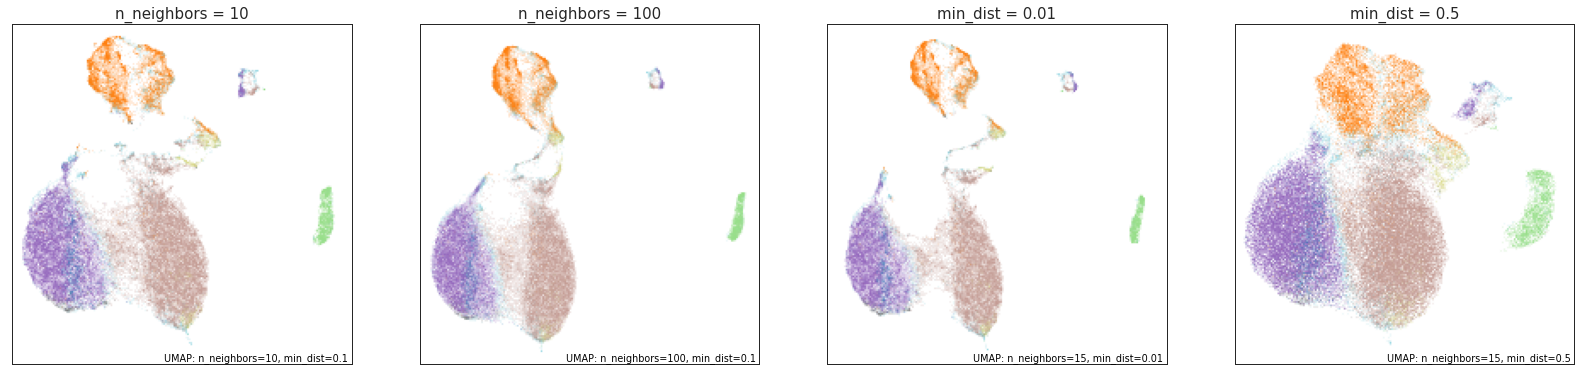

In [145]:
#hide_input
def mapping(nrows=1, ncols=1, n_neighbors=15, min_dist=0.1, title='', ax=ax):
    mapper = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=42
    ).fit(umap_data)
    
    return mapper


#hide_input
sns.set_context('paper')
fig, axes = plt.subplots(1, 4, figsize=(28, 7))

umap.plot.points(mapping(n_neighbors=10), labels=leuko.subtype, theme='blue', width=200, height=200, ax=axes[0], show_legend=False)
axes[0].set_title(f'n_neighbors = {10}', fontsize=15)

umap.plot.points(mapping(n_neighbors=100), labels=leuko.subtype, theme='blue', width=200, height=200, ax=axes[1], show_legend=False)
axes[1].set_title(f'n_neighbors = {100}', fontsize=15)

umap.plot.points(mapping(min_dist=0.010), labels=leuko.subtype, theme='blue', width=200, height=200, ax=axes[2], show_legend=False)
axes[2].set_title(f'min_dist = {0.01}', fontsize=15)

umap.plot.points(mapping(min_dist=0.5), labels=leuko.subtype, theme='blue', width=200, height=200, ax=axes[3], show_legend=False)
axes[3].set_title(f'min_dist = {0.5}', fontsize=15)

plt.show()

#### Conclusion

- A low number of **neighbours** conserves local structure while a high value focuses more on global structure and loses fine details.  
- Larger **distance** results in less packed clusters and loses focus on global structure.

The point is to find an ideal balance for your problematic.

### Diagnostic and connectivity

In [29]:
#hide
mapper = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        random_state=42).fit(umap_data)

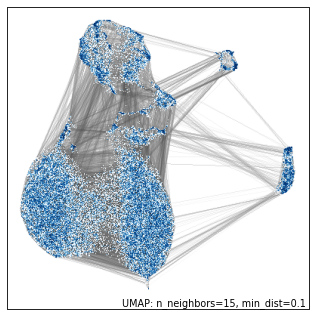

In [35]:
umap.plot.connectivity(mapper, show_points=True, width=400, height=400)
plt.show()

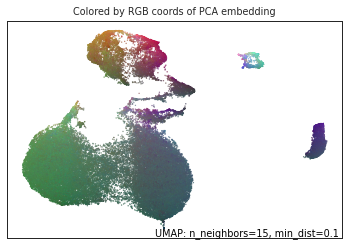

In [37]:
umap.plot.diagnostic(mapper, diagnostic_type='pca', width=400, height=400)
plt.show()

In [56]:
#hide
embedder_1 = load_ParametricUMAP('../../Figure_article/UMAP/nb/models/embedder_1/')
graph = pd.concat([pd.DataFrame(embedder_1.embedding_, columns=['UMAP 1', 'UMAP 2']), leuko[['sample', 'subtype']]], axis=1).sort_values('subtype')
graph = graph.replace({'R1':'F4/80⁺MHCIIʰᶦ', 'R2':'F4/80⁺MHCIIˡᵒ','R3':'Ly6C⁺MHCIIʰᶦ','R4':'Ly6C⁺',
                      'CCR2+':'F4/80⁺MHCIIʰᶦCCR2⁺','PMNs':'neutrophils','LIN+':'lymphocytes'})
graph.subtype.unique()

Pickle of ParametricUMAP model loaded from ../../Figure_article/UMAP/nb/models/embedder_1/model.pkl
Keras encoder model loaded from ../../Figure_article/UMAP/nb/models/embedder_1/encoder
Keras full model loaded from ../../Figure_article/UMAP/nb/models/embedder_1/parametric_model


array(['F4/80⁺MHCIIʰᶦCCR2⁺', 'lymphocytes', 'neutrophils',
       'F4/80⁺MHCIIʰᶦ', 'F4/80⁺MHCIIˡᵒ', 'Ly6C⁺MHCIIʰᶦ', 'Ly6C⁺',
       'leukocytes'], dtype=object)

## Parametric UMAP

Parametric UMAP is really powerful as it relies on a [neural network](https://umap-learn.readthedocs.io/en/latest/parametric_umap.html) to tune the hyperparameters. You can tune the network if needed but I found that it performed really well out of the box. 

Loss is binary cross-entropy so we need to scale the data in range 0-1 with min max scaler:

<div>
<img src=attachment:71b52132-ce60-46e7-9223-9d3a00cb638a.png width="200"/>
</div>

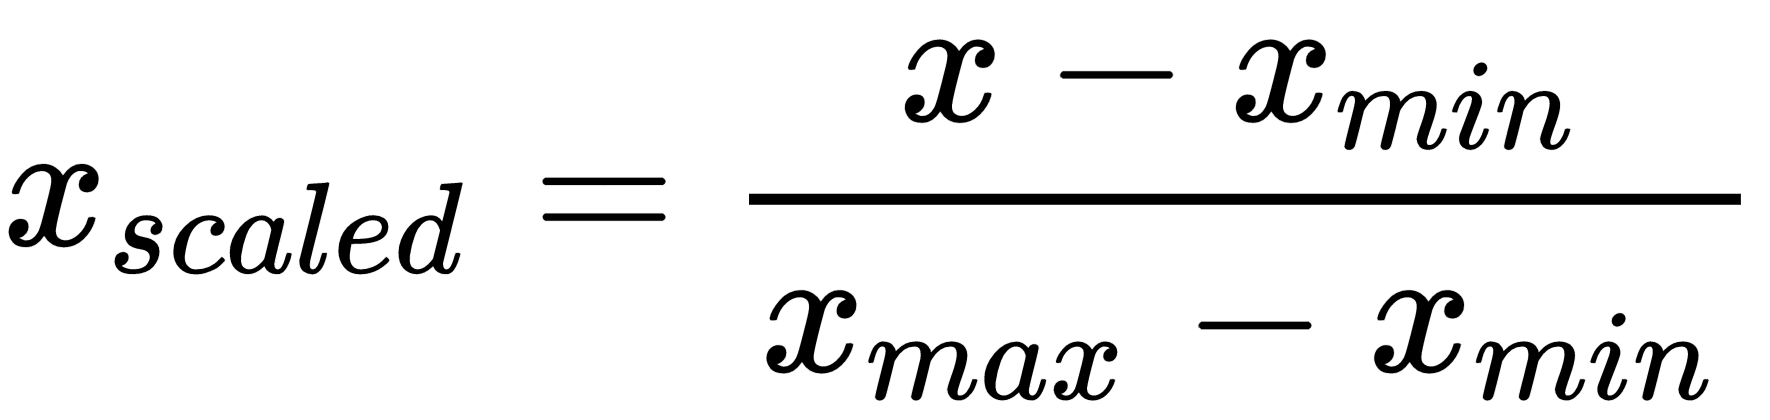

In [149]:
#hide
embedder = embedder_1

In [151]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()
scaled_umap_data = scale.fit_transform(umap_data)

embedder = ParametricUMAP()
embedding = embedder.fit_transform(scaled_umap_data)

embedder.encoder.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 10)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 100)               1100      
_________________________________________________________________
dense_34 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_35 (Dense)             (None, 100)               10100     
_________________________________________________________________
z (Dense)                    (None, 2)                 202       
Total params: 21,502
Trainable params: 21,502
Non-trainable params: 0
_________________________________________________________________


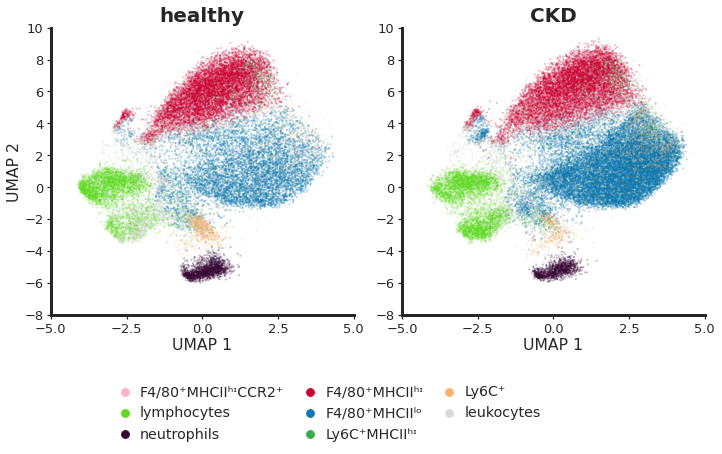

In [148]:
#hide_input
sns.set(font_scale=1.3, style='ticks', context='notebook', font='Arial', 
        rc={"axes.linewidth": 3,
           "xtick.major.size": 4, "ytick.major.size": 4,
            'legend.handletextpad': 0.05,
            'legend.markerscale': 1.3,
            'axes.labelpad': 2.0,
            'legend.columnspacing': 0.8,
            })

g = sns.relplot(x='UMAP 1', y='UMAP 2', data=graph, hue='subtype', col='sample', col_order=['sham', 'nx'],
            s=4, alpha=0.3, marker='o',
            linewidth=0, 
            palette=sns.xkcd_palette(['powder pink', 'green apple', 'eggplant', 'cherry',
                                     'nice blue', 'medium green', 'apricot', 'light grey']),
            facet_kws={'sharey': False,
                      'legend_out': True}, 
               )

for ax, title in zip(g.axes.flat, ['healthy', 'CKD']):
    ax.set_title(title, fontsize=20, fontweight='semibold')

    
g._legend.set_title('')
g.set_xticklabels(fontsize=13)
g.set_yticklabels(fontsize=13)
g.set(ylim=(-8, 10))
plt.subplots_adjust(wspace=0.16)
g._legend.remove()
h, l = g.axes[0,0].get_legend_handles_labels()
plt.legend(h, l , ncol=3, bbox_to_anchor=(0.5, -0.2), frameon=False)
plt.show()

# Conclusion

Parametric UMAP was similar tp non-parametric and showed clusters in a truly consistent embedding. The downside is that it offers less tuning possibilities as compared to non-parametric UMAP. Most flow analysis software offers easy access to UMAP analysis but the original package offers wider potentialities that are also accessible.

UMAP is a powerful algorithm. I showed its use here in a simple flow cytometry analysis but it has a numerous biological applications from flow to RNA sequencing. 